## <font size=5> <strong>Analysis about ED
 

## I. Importing essential libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import os
import warnings

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout, Embedding
from keras.losses import CategoricalCrossentropy
from keras.optimizers import SGD, Adam
warnings.filterwarnings('ignore')

## II. Importing and understanding our dataset 

In [2]:
dataset_ed = pd.read_csv('ED.csv')
dataset_b12 = pd.read_csv('B12.csv')
dateset_bmx = pd.read_csv('BMX_B.csv')
dataset_demo = pd.read_csv('DEMO_B.csv')

#### Create interviewee info data

In [3]:
info_dataset = pd.merge(dataset_demo, dateset_bmx, on='SEQN', how='left')
info_dataset = info_dataset.loc[:, ['BMXWT', 'SEQN', 'BMXHT', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1']]

#### Merge datasets and remove SQEN col, reset index, drop unused cols

In [4]:
merged_dataset = pd.merge(dataset_ed, dataset_b12, on='SEQN', how='left')
merged_dataset = merged_dataset.loc[:, ['KIQ400', 'LBDFOLSI', 'LBDB12SI', 'SEQN']]
merged_dataset = pd.merge(info_dataset, merged_dataset, on='SEQN', how='left')
merged_dataset = merged_dataset.drop(columns=['SEQN'])

In [5]:
print(merged_dataset)

       BMXWT  BMXHT  RIAGENDR  RIDAGEYR  RIDRETH1  KIQ400  LBDFOLSI  LBDB12SI
0       91.7  174.2       1.0      39.0       3.0     1.0      22.4    305.53
1       84.0  167.4       1.0      23.0       4.0     1.0      39.4    687.82
2       51.7  144.9       2.0      84.0       3.0     NaN       NaN       NaN
3       58.0  161.4       2.0      51.0       3.0     NaN       NaN       NaN
4      139.1  188.3       1.0      16.0       2.0     NaN       NaN       NaN
...      ...    ...       ...       ...       ...     ...       ...       ...
11034   66.7  156.5       2.0      10.0       3.0     NaN       NaN       NaN
11035   10.0    NaN       1.0       0.0       3.0     NaN       NaN       NaN
11036   37.7  134.5       1.0      10.0       5.0     NaN       NaN       NaN
11037   31.5  145.0       1.0       9.0       4.0     NaN       NaN       NaN
11038   72.9  170.6       1.0      31.0       2.0     1.0      23.6    312.91

[11039 rows x 8 columns]


#### Delete rows including na

In [6]:
merged_dataset = merged_dataset.dropna()
print(merged_dataset)

       BMXWT  BMXHT  RIAGENDR  RIDAGEYR  RIDRETH1  KIQ400  LBDFOLSI  LBDB12SI
0       91.7  174.2       1.0      39.0       3.0     1.0      22.4    305.53
1       84.0  167.4       1.0      23.0       4.0     1.0      39.4    687.82
6      101.5  173.2       1.0      44.0       3.0     1.0      43.3    341.69
10      72.3  179.2       1.0      36.0       3.0     1.0      42.4    460.51
13      57.3  160.2       1.0      60.0       5.0     2.0      52.5    474.53
...      ...    ...       ...       ...       ...     ...       ...       ...
11020   85.8  183.7       1.0      44.0       3.0     1.0      29.2    442.06
11022   84.7  175.7       1.0      40.0       4.0     1.0      19.0    370.48
11027   64.5  157.7       1.0      32.0       1.0     2.0      16.1    366.79
11033   82.0  169.5       1.0      85.0       3.0     4.0      40.1    346.12
11038   72.9  170.6       1.0      31.0       2.0     1.0      23.6    312.91

[1990 rows x 8 columns]


#### Delete incorrect data

In [7]:
drop_index = merged_dataset[merged_dataset['KIQ400'].isin([7, 9])].index
print(drop_index, 'deleted.')
merged_dataset.drop(drop_index, inplace=True)

drop_index = merged_dataset[merged_dataset['LBDB12SI'] > 5000].index
print(drop_index, 'deleted')
merged_dataset.drop(drop_index, inplace=True)

drop_index = merged_dataset[merged_dataset['LBDFOLSI'] > 500].index
print(drop_index, 'deleted')
merged_dataset.drop(drop_index, inplace=True)

drop_index = merged_dataset[merged_dataset['RIAGENDR'] == 2].index
print(drop_index, 'deleted')
merged_dataset.drop(drop_index, inplace=True)
merged_dataset = merged_dataset.drop(columns=['RIAGENDR'])

merged_dataset = merged_dataset.reset_index(drop=True)

print(merged_dataset)

Int64Index([  140,   284,   654,  1058,  1164,  1427,  1785,  2512,  2782,
             3176,  3539,  3590,  4670,  5692,  5975,  6842,  7095,  7169,
             7250,  7522,  7660,  7670,  7899,  8276,  8290,  9447,  9801,
             9825,  9938,  9950,  9966, 10149, 10216, 10306, 10753, 10868],
           dtype='int64') deleted.
Int64Index([2830, 5694, 8358], dtype='int64') deleted
Int64Index([], dtype='int64') deleted
Int64Index([], dtype='int64') deleted
      BMXWT  BMXHT  RIDAGEYR  RIDRETH1  KIQ400  LBDFOLSI  LBDB12SI
0      91.7  174.2      39.0       3.0     1.0      22.4    305.53
1      84.0  167.4      23.0       4.0     1.0      39.4    687.82
2     101.5  173.2      44.0       3.0     1.0      43.3    341.69
3      72.3  179.2      36.0       3.0     1.0      42.4    460.51
4      57.3  160.2      60.0       5.0     2.0      52.5    474.53
...     ...    ...       ...       ...     ...       ...       ...
1946   85.8  183.7      44.0       3.0     1.0      29.2    442.0

#### Analysing the target KIQ400

In [8]:
KIQ400 = merged_dataset['KIQ400']

#### Check correlation between columns

In [9]:
print(merged_dataset.describe())

             BMXWT        BMXHT     RIDAGEYR     RIDRETH1       KIQ400  \
count  1951.000000  1951.000000  1951.000000  1951.000000  1951.000000   
mean     85.669862   174.994567    49.076371     2.763711     1.798565   
std      18.478938     7.630782    17.747772     1.051512     1.027777   
min      45.300000   151.600000    20.000000     1.000000     1.000000   
25%      73.050000   169.800000    35.000000     2.000000     1.000000   
50%      83.400000   175.200000    47.000000     3.000000     1.000000   
75%      94.950000   180.200000    63.000000     3.000000     3.000000   
max     188.300000   198.700000    85.000000     5.000000     4.000000   

          LBDFOLSI     LBDB12SI  
count  1951.000000  1951.000000  
mean     29.963301   366.815044  
std      20.191135   161.502975  
min       2.500000    46.490000  
25%      19.500000   265.680000  
50%      26.500000   338.000000  
75%      36.000000   437.265000  
max     417.900000  2028.760000  


## Exploratory Data Analysis (EDA)

### First, analysing the target variable:

KIQ400      1.000000
RIDAGEYR    0.567538
BMXHT       0.189339
LBDFOLSI    0.158506
BMXWT       0.005458
LBDB12SI    0.004089
RIDRETH1    0.002307
Name: KIQ400, dtype: float64


<Axes: xlabel='None'>

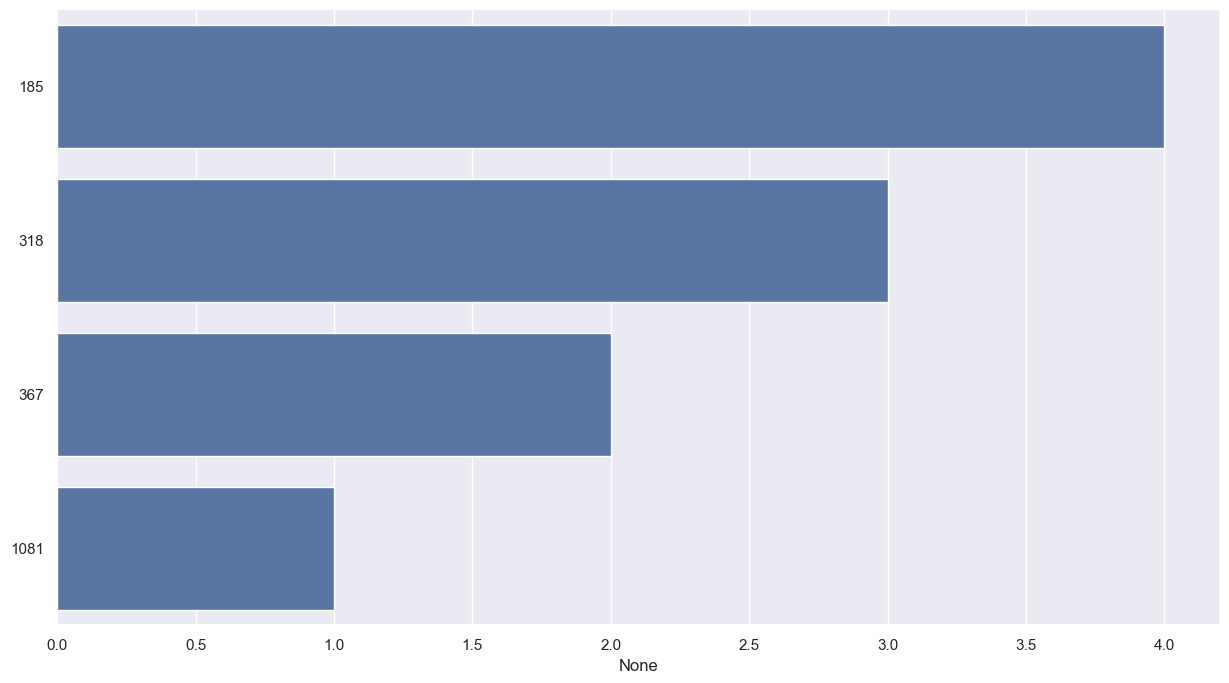

In [80]:
print(merged_dataset.corr()['KIQ400'].abs().sort_values(ascending=False))

value_counts = KIQ400.value_counts().sort_index()

sns.barplot(x=value_counts.index, y=value_counts.values, orient='h')

# plt.xticks([0, 1, 2, 3, 4])
# plt.xlabel('KIQ400 level')
# plt.ylabel('Count')
# plt.title('KIQ400 level Count')
# plt.show()

### Analysing the all features

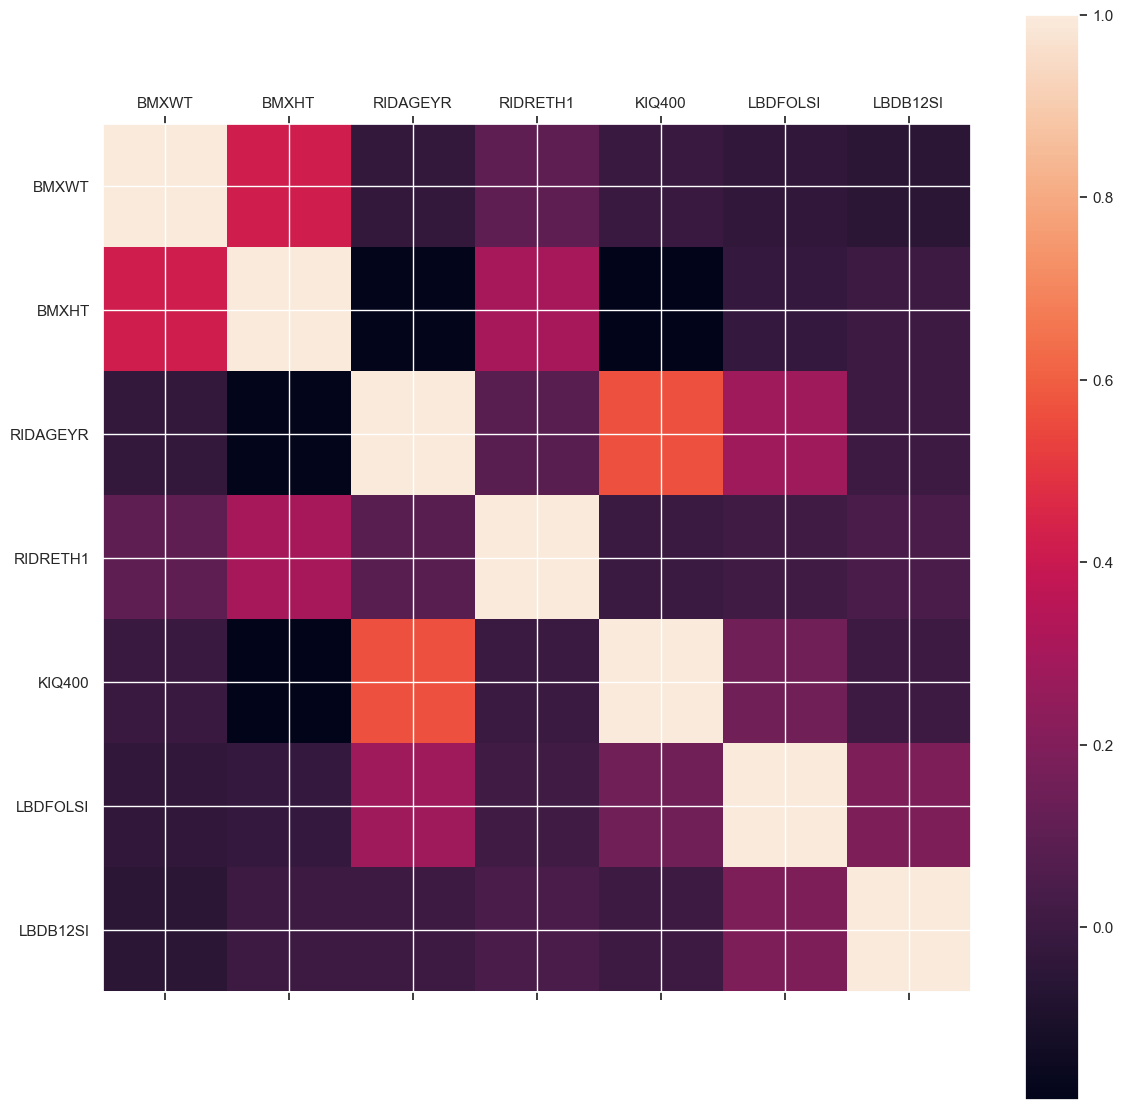

In [82]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(merged_dataset.corr())
plt.yticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.xticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.colorbar()
plt.show()

## IV. Train Test split

In [12]:
predictors = merged_dataset.drop("KIQ400", axis=1)
# normalization
# for col in predictors.columns:
#     predictors[col] = (predictors[col] - predictors[col].min()) / (predictors[col].max() - predictors[col].min())

# print(predictors)
target = merged_dataset["KIQ400"]

X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, test_size=0.20, random_state=32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1560, 6) (391, 6) (1560,) (391,)


## V. Model Fitting

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

In [18]:
Y_pred_lr.shape

(391,)

In [19]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 59.59 %


### Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)

In [21]:
Y_pred_nb.shape

(391,)

In [22]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)

print("The accuracy score achieved using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score achieved using Naive Bayes is: 57.54 %


### SVM

In [23]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, Y_train)

Y_pred_svm = sv.predict(X_test)

In [24]:
Y_pred_svm.shape

(391,)

In [25]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 57.54 %


### K Nearest Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [27]:
Y_pred_knn.shape

(391,)

In [28]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 57.8 %


### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)

In [30]:
print(Y_pred_dt.shape)

(391,)


In [31]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 54.73 %


### XGBoost

In [32]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)

In [33]:
Y_pred_xgb.shape

(391,)

In [54]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")

The accuracy score achieved using XGBoost is: 9.97 %


### Neural Network

In [70]:
# https://stats.stackexchange.com/a/136542 helped a lot in avoiding overfitting

model = Sequential()
model.add(Dense(32,activation='relu',input_dim=6))
model.add(Dense(1,activation='sigmoid'))

adam = Adam(learning_rate=0.01, weight_decay=1e-6)
model.compile(loss=CategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=300, batch_size=16)

Epoch 1/300
98/98 [==============================] - 0s 825us/step - loss: 0.0000e+00 - accuracy: 0.5372
Epoch 2/300
98/98 [==============================] - 0s 784us/step - loss: 0.0000e+00 - accuracy: 0.5462
Epoch 3/300
98/98 [==============================] - 0s 763us/step - loss: 0.0000e+00 - accuracy: 0.5500
Epoch 4/300
98/98 [==============================] - 0s 773us/step - loss: 0.0000e+00 - accuracy: 0.5462
Epoch 5/300
98/98 [==============================] - 0s 763us/step - loss: 0.0000e+00 - accuracy: 0.5487
Epoch 6/300
98/98 [==============================] - 0s 753us/step - loss: 0.0000e+00 - accuracy: 0.5481
Epoch 7/300
98/98 [==============================] - 0s 773us/step - loss: 0.0000e+00 - accuracy: 0.5481
Epoch 8/300
98/98 [==============================] - 0s 773us/step - loss: 0.0000e+00 - accuracy: 0.5468
Epoch 9/300
98/98 [==============================] - 0s 773us/step - loss: 0.0000e+00 - accuracy: 0.5481
Epoch 10/300
98/98 [==============================] - 0

In [74]:
Y_pred_nn = model.predict(X_test)

13/13 [==============================] - 0s 750us/step


In [75]:
Y_pred_nn.shape

(391, 1)

In [76]:
rounded = [round(x[0]) for x in Y_pred_nn]

Y_pred_nn = rounded

In [77]:
score_nn = round(accuracy_score(Y_pred_nn,Y_test)*100,2)

print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

#Note: Accuracy of 85% can be achieved on the test set, by setting epochs=2000, and number of nodes = 11. 

The accuracy score achieved using Neural Network is: 8.44 %


## VI. Output final score

In [78]:
scores = [score_lr,score_nb,score_svm,score_knn,score_dt,score_xgb,score_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Decision Tree","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Logistic Regression is: 59.59 %
The accuracy score achieved using Naive Bayes is: 57.54 %
The accuracy score achieved using Support Vector Machine is: 57.54 %
The accuracy score achieved using K-Nearest Neighbors is: 57.8 %
The accuracy score achieved using Decision Tree is: 54.73 %
The accuracy score achieved using XGBoost is: 9.97 %
The accuracy score achieved using Neural Network is: 8.44 %


<Axes: xlabel='Algorithms', ylabel='Accuracy score'>

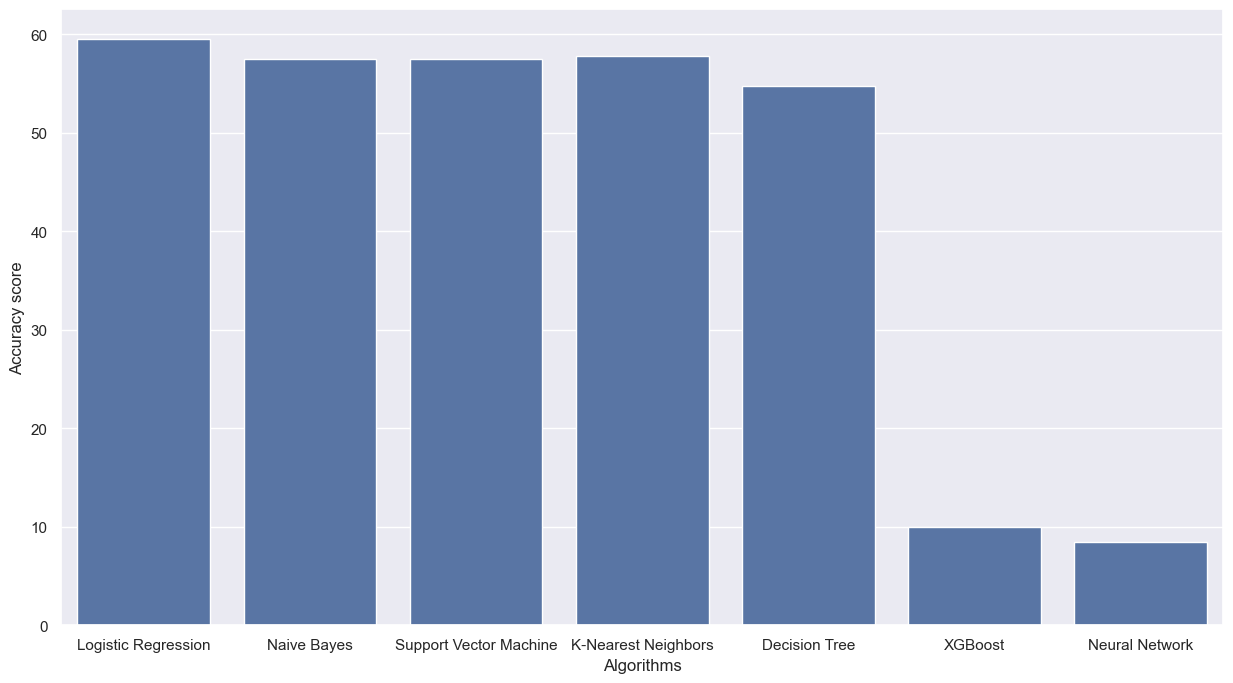

In [79]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(x=algorithms,y=scores)